# Entropy

The Oracle teacher model, which utilizes refined data, outputs reinforced task-specific knowledge – the confidence score for the target class is increased, while the confidence score for non-target classes is decreased. As shown in the below the figure, the entropy, or the expected amount of information, also decreases. However, as demonstrated in our experiments, the knowledge preserves representations among similar classes (refer to t-SNE, silhouette score results). Therefore, we can mitigate the capacity gap issue because task-specific knowledge is extracted regardless of the model's capacity.

In [2]:
import torch.nn as nn
import torch
import sys
import os
sys.path.append(os.path.abspath('../'))

import dataset
import models
import utils

In [ ]:
# Calculate the entropy of the output of the model
def get_entropy(vector):
    normalized_vector = (vector + 1e-8) / torch.sum(vector)
    torch.log2(normalized_vector)
    entropy_value = -torch.sum(normalized_vector * torch.log2(normalized_vector))
    return entropy_value

In [28]:
device = torch.device('cuda')
batch_size = 64

# Initialize and load the ResNet32 model with 100 classes.
model = models.resnet32(num_classes=100)
model.load_state_dict(torch.load((f"../teacher_models/CIFAR100/resnet32/model.pth")))

model = model.to(device)
model.eval()

train_loader, test_loader, _, _ = dataset.create_loader(batch_size, "./data/", "CIFAR100")
datasize =  train_loader.dataset.__len__()

softmax = nn.Softmax(dim=1)

# Initialize a list to store entropy values for different gamma values.
gamma_entropy = []


# Iterate over a range of gamma values from 0 to 10 in steps of 0.1.
for lrp_gamma in range(0, 51):
    lrp_gamma /= 5

    # Initialize the refiner with the current gamma value.
    refiner = utils.Refiner(teacher=model, lrp_gamma=lrp_gamma)

    correct = 0
    entropy = 0

    # ECE is computed using training data, as the teacher model utilizes this data for training the student model
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)

        # Get refined image(reinforced_img)
        refined_img = refiner.get_refined_image(img, label)

        with torch.no_grad():
            output = softmax(model(refined_img) / 4)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            entropy += sum([get_entropy(vector).item() for vector in output])  # Compute and summation entropy

    print(lrp_gamma, ":", entropy / datasize)
    gamma_entropy.append(entropy / datasize)

Files already downloaded and verified
Files already downloaded and verified
0.0 : 5.532861194165349
0.2 : 5.529578017930985
0.4 : 5.52488672971487
0.6 : 5.52069652657032
0.8 : 5.5141953724908825
1.0 : 5.5103131531012055
1.2 : 5.503875810074806
1.4 : 5.498469164617657
1.6 : 5.493542937451005
1.8 : 5.486933969740868
2.0 : 5.487348489611149
2.2 : 5.479310693961382
2.4 : 5.475101574424505
2.6 : 5.471420794582367
2.8 : 5.464708160401583
3.0 : 5.4662763875889775
3.2 : 5.458978559362889
3.4 : 5.455521011030674
3.6 : 5.456232696975469
3.8 : 5.45038414121151
4.0 : 5.446225071183443
4.2 : 5.443354296703339
4.4 : 5.440575729837418
4.6 : 5.439467132258415
4.8 : 5.436648594403267
5.0 : 5.433915465888977
5.2 : 5.4329497364687915
5.4 : 5.426796816284656
5.6 : 5.424093397891522
5.8 : 5.423710737195015
6.0 : 5.4189412765455245
6.2 : 5.417345014095306
6.4 : 5.414403568754196
6.6 : 5.416410812676549
6.8 : 5.412505629894733
7.0 : 5.409144932650924
7.2 : 5.407239236242771
7.4 : 5.40674665012002
7.6 : 5.404

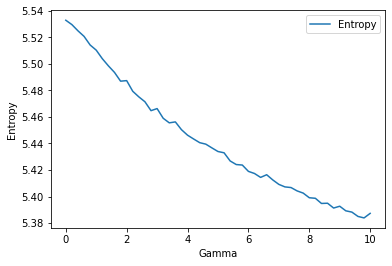

In [29]:
from matplotlib import pyplot as plt

plt.plot([i / 5 for i in range(0, 51)], gamma_entropy, label="Entropy")
plt.xlabel("Gamma")
plt.ylabel("Entropy")
plt.legend()
plt.show()